In [1]:
import pandas as pd
import numpy as np
import talib as ta
import pyupbit as up
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = up.get_ohlcv(ticker="KRW-BTC", interval="day", count=2085)
df.to_csv('bitcoin_data.csv')

In [3]:
df = pd.read_csv('bitcoin_data.csv')
df

,Unnamed: 0,open,high,low,close,volume,value
0,2018-01-04 09:00:00,20899000.0,23685000.0,19700000.0,23402000.0,45192.451742,9.792269e+11
1,2018-01-05 09:00:00,23403000.0,28589000.0,22338000.0,27444000.0,56774.849842,1.418955e+12
2,2018-01-06 09:00:00,27451000.0,28885000.0,23966000.0,26924000.0,48971.928131,1.279383e+12
3,2018-01-07 09:00:00,26924000.0,27210000.0,24543000.0,25859000.0,31015.722586,8.055615e+11
4,2018-01-08 09:00:00,25859000.0,26449000.0,23850000.0,25230000.0,44839.783322,1.135051e+12
...,...,...,...,...,...,...,...
2080,2023-09-15 09:00:00,35872000.0,36193000.0,35547000.0,35928000.0,3336.887555,1.197266e+11
2081,2023-09-16 09:00:00,35907000.0,36051000.0,35800000.0,35938000.0,2192.885125,7.875507e+10
2082,2023-09-17 09:00:00,35939000.0,35996000.0,35650000.0,35758000.0,2014.744093,7.210203e+10
2083,2023-09-18 09:00:00,35758000.0,36801000.0,35658000.0,36000000.0,3943.417510,1.427953e+11


In [4]:
df_data = pd.DataFrame()
df_data['Close'] = df['close']

# 이동평균
df_data['MA5'] = ta.SMA(df['close'], timeperiod=5)
df_data['MA20'] = ta.SMA(df['close'], timeperiod=20)

# RSI
df_data['RSI'] = ta.RSI(df['close'], timeperiod=14)

# MACD
df_data['MACD'], df_data['Signal'], df_data['Hist'] = ta.MACD(df['close'], fastperiod=12, 
                                                          slowperiod=26, signalperiod=9)

# 볼린저 밴드
df_data['Upper'], df_data['Middle'], df_data['Lower'] = ta.BBANDS(df['close'], timeperiod=20, 
                                                               nbdevup=2, nbdevdn=2)

# 스토캐스틱
df_data['SlowK'], df_data['SlowD'] = ta.STOCH(df['high'], df['low'], df['close'], 
                                              fastk_period=5, slowk_period=3, slowd_period=3)

# OBV
df_data['OBV'] = ta.OBV(df['close'], df['volume'])

# ADX
df_data['ADX'] = ta.ADX(df['high'], df['low'], df['close'])

# ATR
df_data['ATR'] = ta.ATR(df['high'], df['low'], df['close'])

# MFI
df_data['MFI'] = ta.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)

# ROC
df_data['ROC'] = ta.ROC(df['close'], timeperiod=10)

# CCI
df_data['CCI'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=20)

# DMI
df_data['DMI+'] = ta.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df_data['DMI-'] = ta.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)

df_data.iloc[100]

Close     8.350000e+06
MA5       7.940600e+06
MA20      7.870950e+06
RSI       4.937304e+01
MACD     -4.239908e+05
Signal   -6.183530e+05
Hist      1.943622e+05
Upper     8.877930e+06
Middle    7.870950e+06
Lower     6.863970e+06
SlowK     8.281189e+01
SlowD     6.950466e+01
OBV      -3.151229e+05
ADX       3.675681e+01
ATR       5.794799e+05
MFI       6.227853e+01
ROC       1.145222e+01
CCI       7.328336e+01
DMI+      2.075897e+01
DMI-      2.326803e+01
Name: 100, dtype: float64

In [5]:
df_data.dropna(inplace=True)
input_var = df_data.columns[df_data.columns != 'Close']

input_var_trends = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-']
input_var_elasticity = ['Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR']
input_var_volume = ['OBV']
input_var_market = ['MFI']

input_var_tne = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 
                 'Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR']
input_var_tnv = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 'OBV']
input_var_tnm = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 'MFI']

input_var_env = ['Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR', 'OBV']
input_var_enm = ['Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR', 'MFI']

input_var_vnm = ['OBV', 'MFI']

input_var_plus = ['MA5', 'MA20', 'Upper', 'Middle', 'Lower', 'ATR', 'OBV']

input_var_RSI = ['RSI', 'MACD']

input_var_tnm_plus = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 'MFI',
                     'Upper', 'Middle', 'Lower', 'ATR', 'OBV']

input_var_tnm_plus

['MA5',
 'MA20',
 'RSI',
 'MACD',
 'Signal',
 'Hist',
 'ADX',
 'ROC',
 'CCI',
 'DMI+',
 'DMI-',
 'MFI',
 'Upper',
 'Middle',
 'Lower',
 'ATR',
 'OBV']

In [6]:
df_check=df_data.isnull().any().any()

print(df_check)

False


In [7]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
def lstm_df(df, input_var, degree=2, target_var=['Close']):
    
    df = df.copy()
    X = df[input_var].values
    Y = df[target_var].values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.3, shuffle=False,
                                                    random_state=0)
    
    scaler=MinMaxScaler()
    
    # X 학습 테스트
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # Y 학습 테스트
    Y_train = scaler.fit_transform(Y_train.reshape(-1, 1)).flatten()
    Y_test = scaler.fit_transform(Y_test.reshape(-1, 1)).flatten()

    
    # 모델 구성
    model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', input_shape=(X_train.shape[1],1)),
    tf.keras.layers.Dense(1)
    ])
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='mse')
    
    # 모델 학습
    model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=1)
    
    # 검증
    Y_pred = model.predict(X_test)
    
    # 예측 결과 역스케일링
    Y_pred_scaled = scaler.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
    Y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

    ## r2
    r2_train = r2_score(Y_train, model.predict(X_train))
    r2_test = r2_score(Y_test, Y_pred)

    print(f"[r2_score] train : {r2_train} / test : {r2_test}")
    
    # mse
    mse = mean_squared_error(Y_test, Y_pred)
    # rmse
    rmse = np.sqrt(mse)

    print(f'[MSE] : {mse:.5f}\n[RMSE] : {rmse:.5f}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Actual')
    plt.plot(Y_pred, label='Predicted')
    plt.title('Prediction')
    plt.legend()
    plt.show()

    return r2_train, r2_test, mse, rmse

Epoch 1/50
90/90 [==============================] - 1s 5ms/step - loss: 0.0477
Epoch 2/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 3/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 4/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 5/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 6/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 7/50
90/90 [==============================] - 0s 5ms/step - loss: 5.6938e-04
Epoch 8/50
90/90 [==============================] - 0s 4ms/step - loss: 5.5301e-04
Epoch 9/50
90/90 [==============================] - 0s 5ms/step - loss: 3.8281e-04
Epoch 10/50
90/90 [==============================] - 0s 5ms/step - loss: 5.9919e-04
Epoch 11/50
90/90 [==============================] - 0s 5ms/step - loss: 4.4324e-04
Epoch 12/50
90/90 [==============================] - 0s 5ms/step - loss: 5.6316e-04
Epoch 13/50
90/90 [======

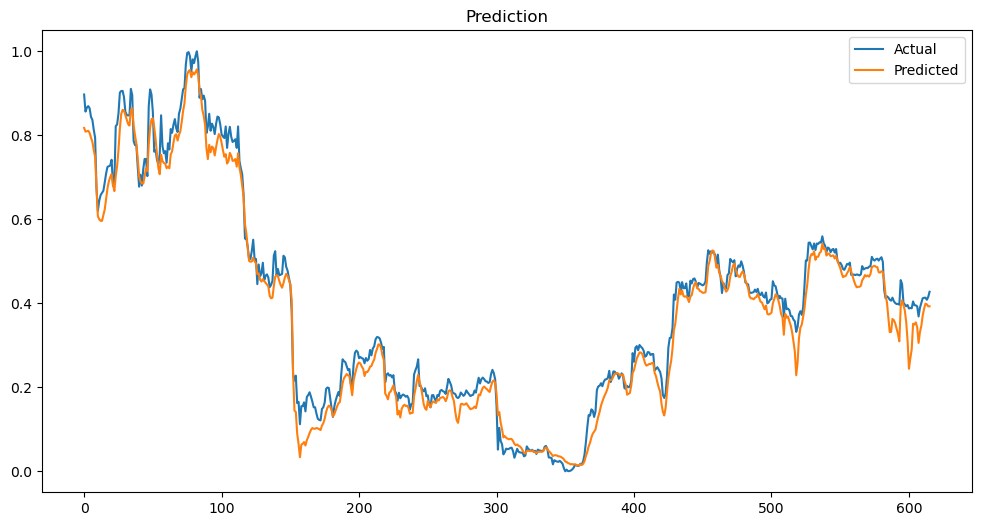

(0.9987376994895555,
 0.9769807626474535,
 0.001445188588130591,
 0.03801563610056513)

In [9]:
lstm_df(df_data, input_var)

Epoch 1/50
90/90 [==============================] - 1s 3ms/step - loss: 0.0524
Epoch 2/50
90/90 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 3/50
90/90 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 4/50
90/90 [==============================] - 0s 3ms/step - loss: 6.2429e-04
Epoch 5/50
90/90 [==============================] - 0s 3ms/step - loss: 5.9449e-04
Epoch 6/50
90/90 [==============================] - 0s 3ms/step - loss: 3.3639e-04
Epoch 7/50
90/90 [==============================] - 0s 3ms/step - loss: 3.1214e-04
Epoch 8/50
90/90 [==============================] - 0s 3ms/step - loss: 3.5763e-04
Epoch 9/50
90/90 [==============================] - 0s 3ms/step - loss: 2.3632e-04
Epoch 10/50
90/90 [==============================] - 0s 3ms/step - loss: 3.2240e-04
Epoch 11/50
90/90 [==============================] - 0s 3ms/step - loss: 2.0638e-04
Epoch 12/50
90/90 [==============================] - 0s 3ms/step - loss: 2.6657e-04
Epoch 13/50
9

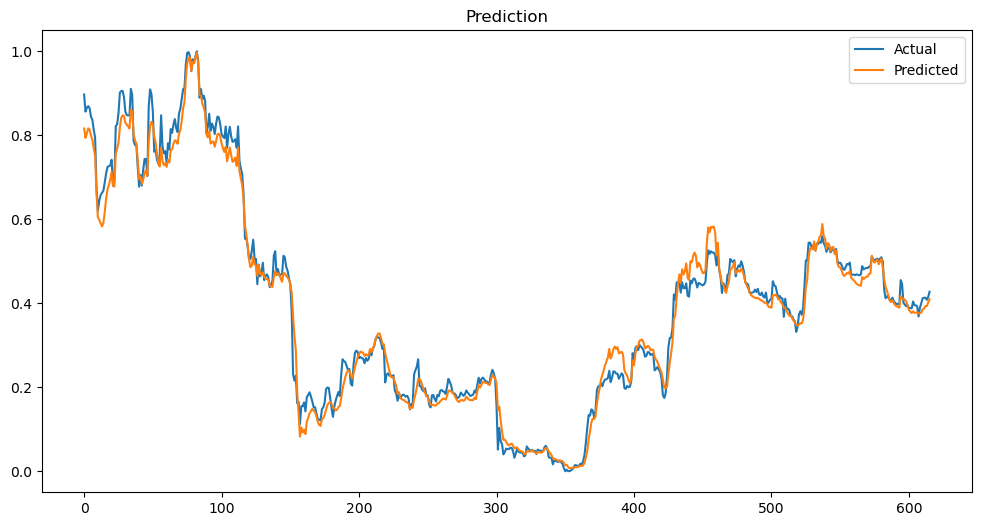

(0.9994064076812472,
 0.9858401373785646,
 0.0008889813140456449,
 0.02981578967670729)

In [10]:
lstm_df(df_data, input_var_trends)

Epoch 1/50
90/90 [==============================] - 1s 2ms/step - loss: 0.0351
Epoch 2/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 3/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 4/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 5/50
90/90 [==============================] - 0s 2ms/step - loss: 9.1096e-04
Epoch 6/50
90/90 [==============================] - 0s 2ms/step - loss: 9.1895e-04
Epoch 7/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 8/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 9/50
90/90 [==============================] - 0s 2ms/step - loss: 9.6697e-04
Epoch 10/50
90/90 [==============================] - 0s 2ms/step - loss: 9.9580e-04
Epoch 11/50
90/90 [==============================] - 0s 2ms/step - loss: 8.4320e-04
Epoch 12/50
90/90 [==============================] - 0s 2ms/step - loss: 9.6272e-04
Epoch 13/50
90/90 [======

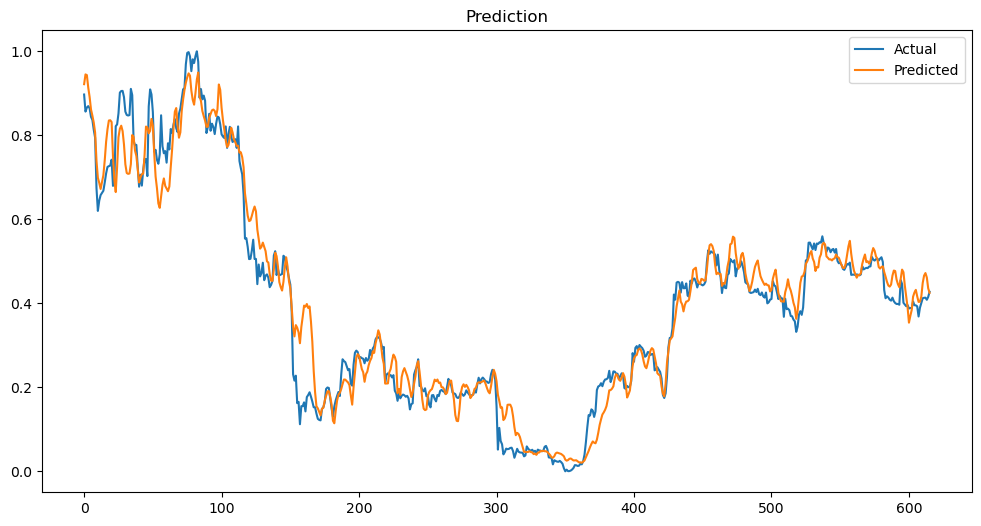

(0.9910148915591975,
 0.954161252387469,
 0.002877837954805216,
 0.053645484011286694)

In [11]:
lstm_df(df_data, input_var_elasticity)

Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.0849
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0559
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0489
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0389
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0337
Epoch 8/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0313
Epoch 9/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0284
Epoch 10/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 11/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0251
Epoch 12/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 13/50
90/90 [==============================

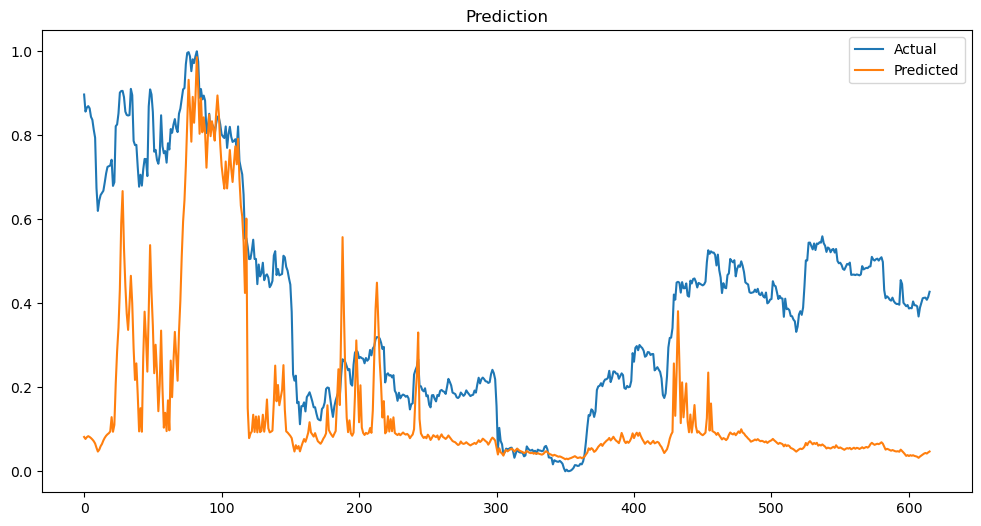

(0.7263447794140869,
 -0.5353226599651788,
 0.09639028232334222,
 0.3104678442662657)

In [12]:
lstm_df(df_data, input_var_volume)

Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.0969
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0804
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0804
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0797
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0797
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0796
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 8/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 9/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0793
Epoch 10/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0793
Epoch 11/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0792
Epoch 12/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0791
Epoch 13/50
90/90 [==============================

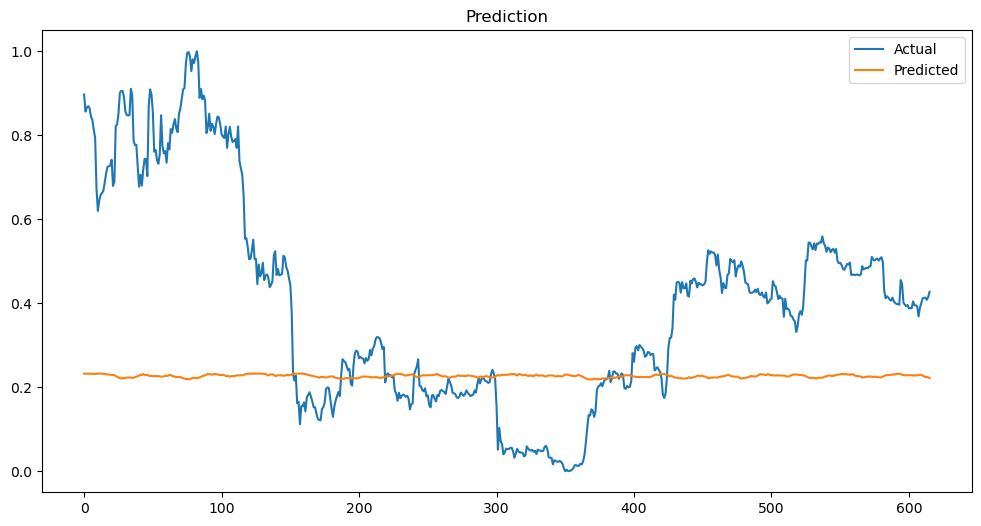

(-0.0016750884969760627,
 -0.46209617897487143,
 0.09179299384434546,
 0.30297358605057545)

In [13]:
lstm_df(df_data, input_var_market)

Epoch 1/50
90/90 [==============================] - 1s 4ms/step - loss: 0.0376
Epoch 2/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 5/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 6/50
90/90 [==============================] - 0s 4ms/step - loss: 5.6063e-04
Epoch 7/50
90/90 [==============================] - 0s 4ms/step - loss: 4.7565e-04
Epoch 8/50
90/90 [==============================] - 0s 4ms/step - loss: 4.3692e-04
Epoch 9/50
90/90 [==============================] - 0s 4ms/step - loss: 2.9049e-04
Epoch 10/50
90/90 [==============================] - 0s 4ms/step - loss: 2.8419e-04
Epoch 11/50
90/90 [==============================] - 0s 4ms/step - loss: 2.4524e-04
Epoch 12/50
90/90 [==============================] - 0s 4ms/step - loss: 2.2923e-04
Epoch 13/50
90/90 [==

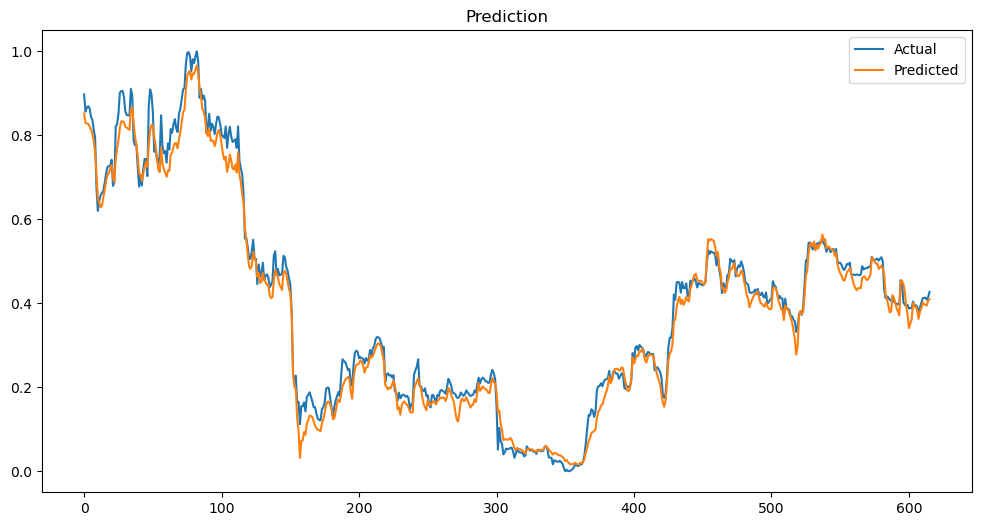

(0.999106487293414,
 0.9859349526769023,
 0.0008830286412859302,
 0.029715797840305924)

In [14]:
lstm_df(df_data, input_var_tne)

Epoch 1/50
90/90 [==============================] - 1s 3ms/step - loss: 0.0496
Epoch 2/50
90/90 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3/50
90/90 [==============================] - 0s 3ms/step - loss: 9.5670e-04
Epoch 4/50
90/90 [==============================] - 0s 3ms/step - loss: 6.2671e-04
Epoch 5/50
90/90 [==============================] - 0s 3ms/step - loss: 6.8942e-04
Epoch 6/50
90/90 [==============================] - 0s 3ms/step - loss: 4.5035e-04
Epoch 7/50
90/90 [==============================] - 0s 3ms/step - loss: 4.1863e-04
Epoch 8/50
90/90 [==============================] - 0s 3ms/step - loss: 3.7152e-04
Epoch 9/50
90/90 [==============================] - 0s 3ms/step - loss: 3.0945e-04
Epoch 10/50
90/90 [==============================] - 0s 3ms/step - loss: 5.6787e-04
Epoch 11/50
90/90 [==============================] - 0s 3ms/step - loss: 3.0111e-04
Epoch 12/50
90/90 [==============================] - 0s 3ms/step - loss: 2.8603e-04
Epoch 13/

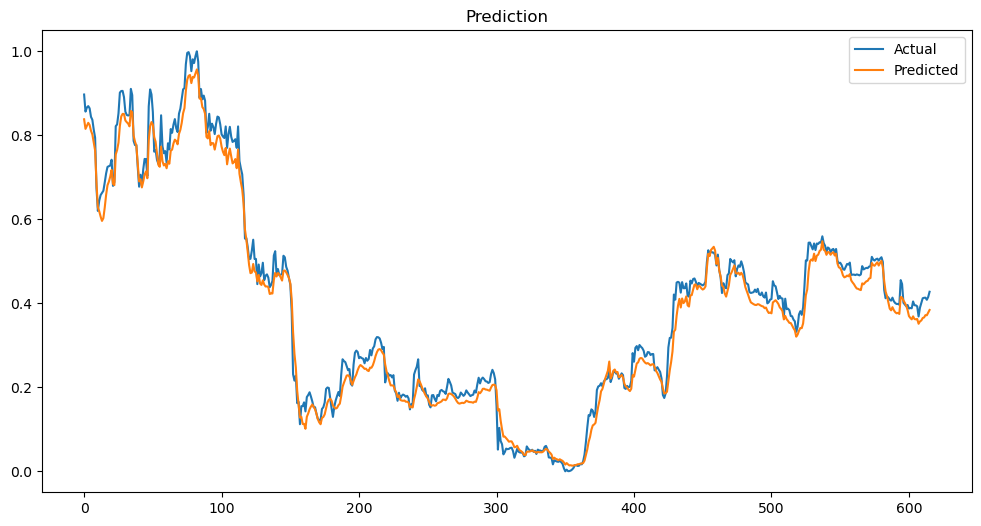

(0.9990929508520269,
 0.9848375640479844,
 0.0009519246476551906,
 0.030853276125157123)

In [15]:
lstm_df(df_data, input_var_tnv)

Epoch 1/50
90/90 [==============================] - 1s 3ms/step - loss: 0.0541
Epoch 2/50
90/90 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 3/50
90/90 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 4/50
90/90 [==============================] - 0s 3ms/step - loss: 7.0937e-04
Epoch 5/50
90/90 [==============================] - 0s 3ms/step - loss: 5.3704e-04
Epoch 6/50
90/90 [==============================] - 0s 3ms/step - loss: 3.3280e-04
Epoch 7/50
90/90 [==============================] - 0s 3ms/step - loss: 3.3220e-04
Epoch 8/50
90/90 [==============================] - 0s 3ms/step - loss: 2.9395e-04
Epoch 9/50
90/90 [==============================] - 0s 3ms/step - loss: 2.2334e-04
Epoch 10/50
90/90 [==============================] - 0s 3ms/step - loss: 2.5704e-04
Epoch 11/50
90/90 [==============================] - 0s 3ms/step - loss: 2.1084e-04
Epoch 12/50
90/90 [==============================] - 0s 3ms/step - loss: 2.1901e-04
Epoch 13/50
9

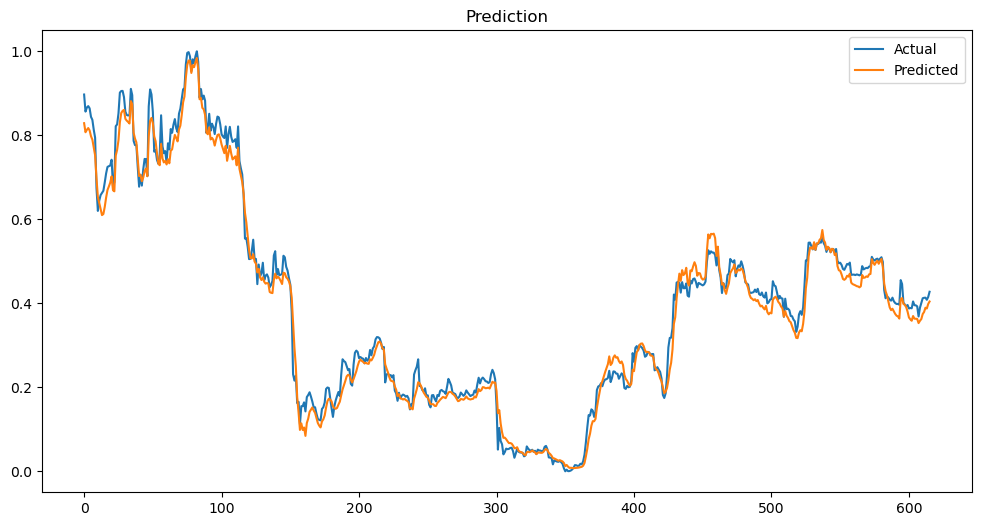

(0.999008831771573,
 0.9874412418878836,
 0.0007884611304342501,
 0.028079550039739776)

In [16]:
lstm_df(df_data, input_var_tnm)

Epoch 1/50
90/90 [==============================] - 1s 2ms/step - loss: 0.0268
Epoch 2/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 3/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 4/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 5/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 6/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0010
Epoch 7/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 8/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 9/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 10/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 11/50
90/90 [==============================] - 0s 2ms/step - loss: 9.7324e-04
Epoch 12/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 13/50
90/90 [==========================

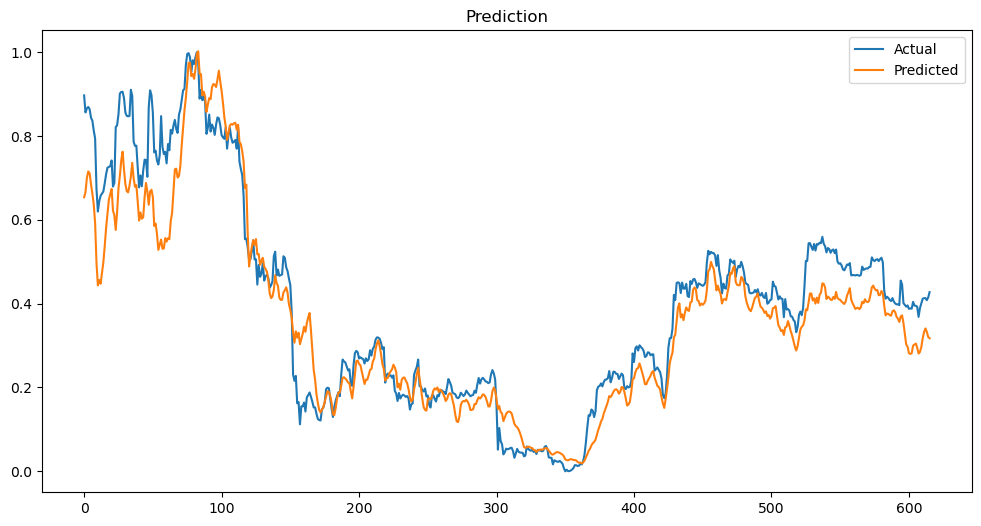

(0.9929317613441692,
 0.895015834427033,
 0.0065910922980113515,
 0.0811855424198875)

In [17]:
lstm_df(df_data, input_var_env)

Epoch 1/50
90/90 [==============================] - 1s 2ms/step - loss: 0.0309
Epoch 2/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 3/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 4/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 5/50
90/90 [==============================] - 0s 2ms/step - loss: 8.2643e-04
Epoch 6/50
90/90 [==============================] - 0s 2ms/step - loss: 6.6576e-04
Epoch 7/50
90/90 [==============================] - 0s 2ms/step - loss: 5.9729e-04
Epoch 8/50
90/90 [==============================] - 0s 2ms/step - loss: 5.6849e-04
Epoch 9/50
90/90 [==============================] - 0s 2ms/step - loss: 4.7886e-04
Epoch 10/50
90/90 [==============================] - 0s 2ms/step - loss: 5.7537e-04
Epoch 11/50
90/90 [==============================] - 0s 2ms/step - loss: 3.5569e-04
Epoch 12/50
90/90 [==============================] - 0s 2ms/step - loss: 3.4055e-04
Epoch 13/50
90/90

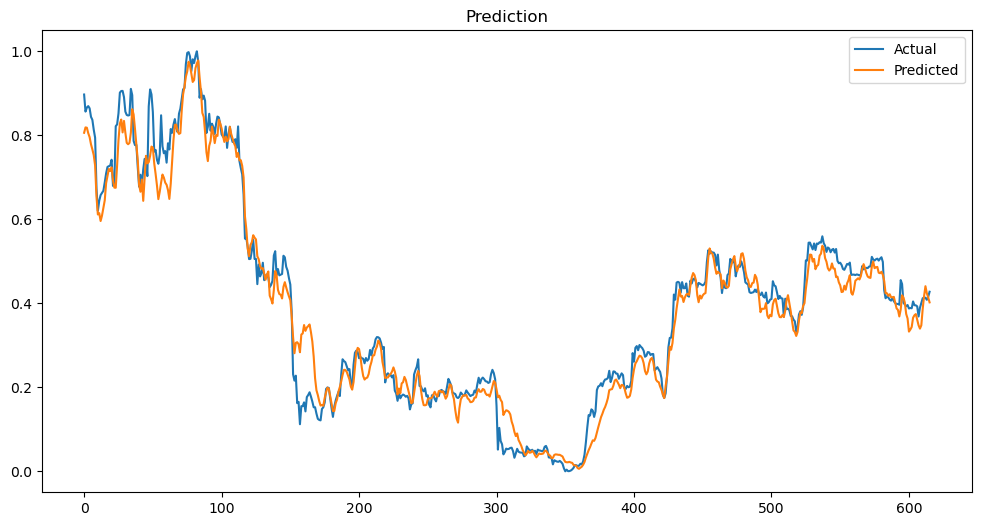

(0.9976202055312409,
 0.9664015277588445,
 0.002109371736252112,
 0.04592789714598429)

In [18]:
lstm_df(df_data, input_var_enm)

Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.0763
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0476
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 8/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 9/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 10/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 11/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 12/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 13/50
90/90 [==============================

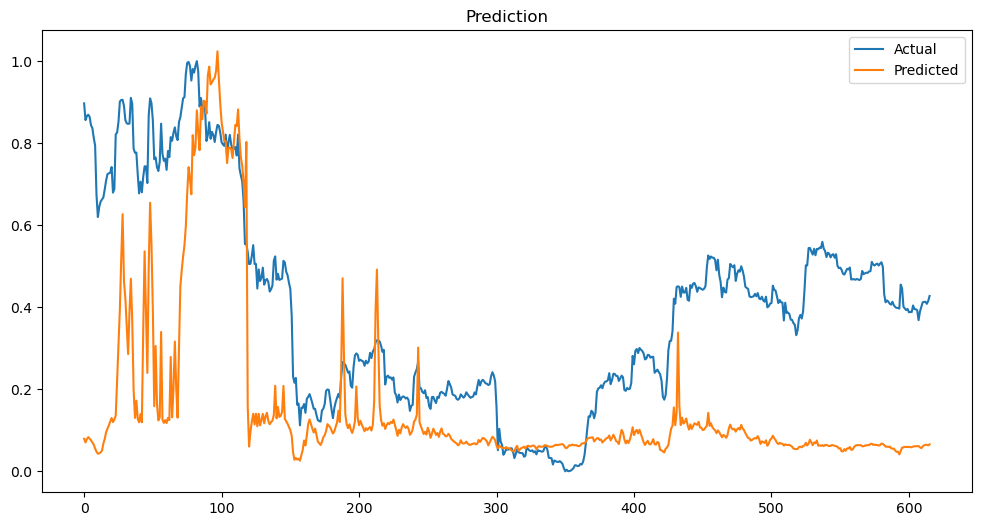

(0.7913793506913249,
 -0.5618113120579722,
 0.09805328692828114,
 0.3131346147079258)

In [19]:
lstm_df(df_data, input_var_vnm)

Epoch 1/50
90/90 [==============================] - 1s 2ms/step - loss: 0.0172
Epoch 2/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 3/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 4/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 5/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 6/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 7/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 8/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 9/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 10/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 11/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 12/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 13/50
90/90 [==============================

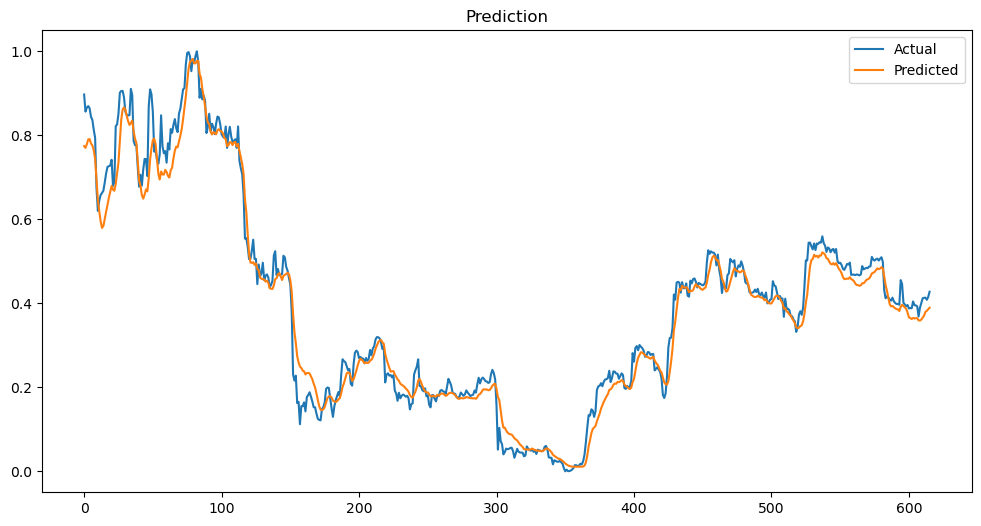

(0.9968329724081729,
 0.9751368793529294,
 0.0015609508548937942,
 0.03950887058489263)

In [20]:
lstm_df(df_data, input_var_plus)

Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.0872
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0758
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0751
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0730
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0713
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0693
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0666
Epoch 8/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 9/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0619
Epoch 10/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0594
Epoch 11/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0568
Epoch 12/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0532
Epoch 13/50
90/90 [==============================

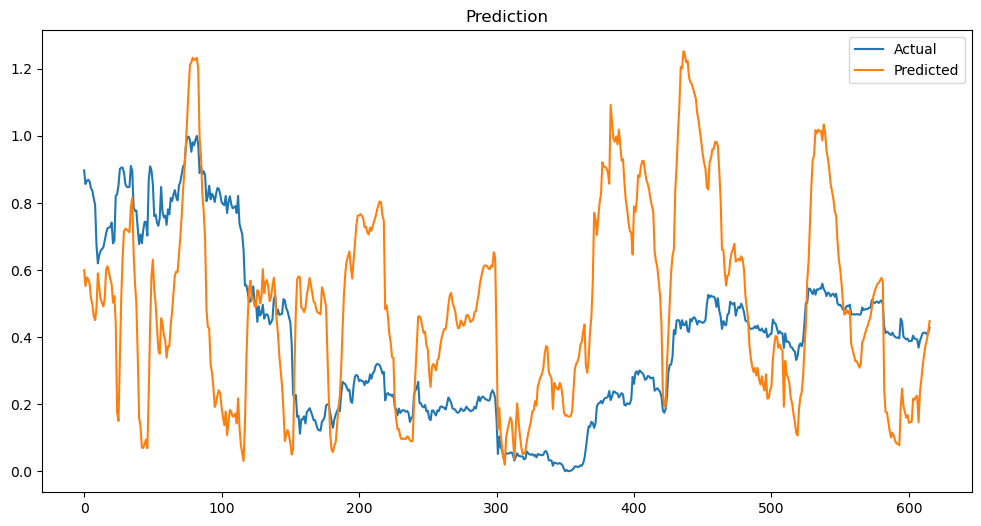

(0.660214012327353,
 -0.9125924963648215,
 0.12007595243744544,
 0.3465197720728868)

In [21]:
lstm_df(df_data, input_var_RSI)

Epoch 1/50
90/90 [==============================] - 1s 4ms/step - loss: 0.0294
Epoch 2/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 3/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 4/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 5/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 6/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 8/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 9/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 10/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 12/50
90/90 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/50
90/90 [==============================

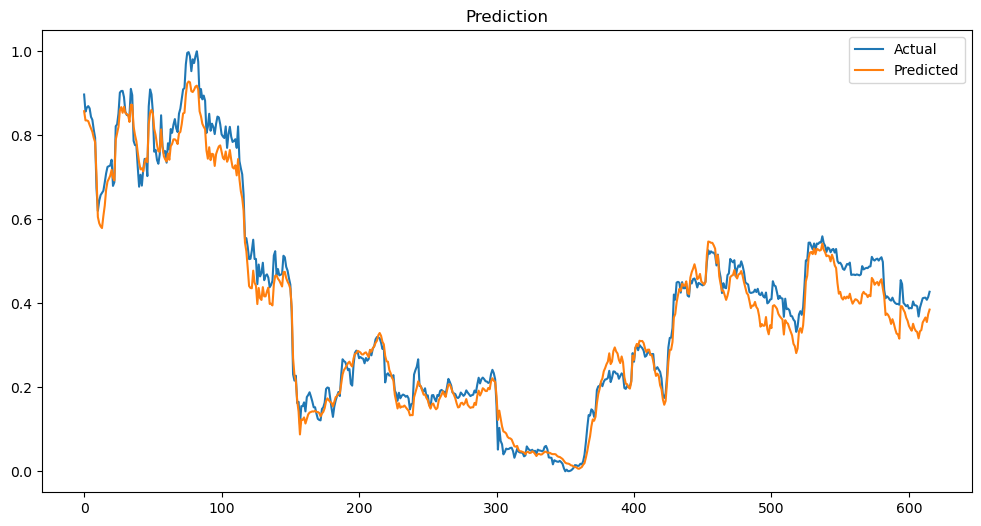

(0.9978608105046858,
 0.9772232313912844,
 0.001429965969926691,
 0.037814890849064885)

In [22]:
lstm_df(df_data, input_var_tnm_plus)